In [28]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, TrainerCallback
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
from peft import get_peft_model, LoraConfig, TaskType
import evaluate
import bert_score
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [4]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00


In [5]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=cb72403dba29605804f7310959a17d6ab81050f927637d9f8b52bbcec9e3c975
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [6]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

# Model

In [8]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id="IlyaGusev/saiga_llama3_8b", local_dir="saiga_llama3_8b", resume_download=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

'/content/saiga_llama3_8b'

In [9]:
model_name = "saiga_llama3_8b"
device = torch.device("cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="cuda")
model.eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [10]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_config)

In [11]:
df = pd.read_csv("sft_dataset.csv")
ds = Dataset.from_pandas(df[["prompt", "response"]])

In [12]:
def preprocess(examples):
    inputs = [
        f"<s>Вопрос: {q.strip()}\nОтвет:" for q in examples["prompt"]
    ]
    targets = [a.strip() for a in examples["response"]]
    full_texts = [i + " " + t for i, t in zip(inputs, targets)]
    encodings = tokenizer(
        full_texts,
        truncation=True,
        max_length=1024,
        padding="max_length"
    )
    encodings["labels"] = encodings["input_ids"].copy()
    return encodings

In [13]:
ds = ds.map(preprocess, batched=True)

Map:   0%|          | 0/1604 [00:00<?, ? examples/s]

In [14]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Training

In [15]:
training_args = TrainingArguments(
    output_dir="./sft-saiga-llama3-8b",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    fp16=True,
    save_steps=100,
    save_total_limit=2,
    logging_steps=20,
    report_to="none"
)

In [16]:
gc.collect()
torch.cuda.empty_cache()

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds,
    data_collator=data_collator,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
import time

start_time = time.time()

trainer.train()

end_time = time.time()
total_time = end_time - start_time
print(f"\nВремя обучения: {total_time / 60:.2f} минут ({total_time:.1f} секунд)")

Step,Training Loss
20,1.848500
40,1.748400
60,1.703900
80,1.612800
100,1.553700
120,1.515600
140,1.488800
160,1.483300
180,1.442700
200,1.469400



Время обучения: 18.41 минут (1104.7 секунд)


In [19]:
model.save_pretrained("./sft-saiga-llama3-8b")
tokenizer.save_pretrained("./sft-saiga-llama3-8b")

('./sft-saiga-llama3-8b/tokenizer_config.json',
 './sft-saiga-llama3-8b/special_tokens_map.json',
 './sft-saiga-llama3-8b/tokenizer.json')

# Testing

In [20]:
df = pd.read_csv("sft_dataset.csv")
prompts = df["prompt"].iloc[:50].tolist()
refs = df["response"].iloc[:50].tolist()

In [21]:
def complete_sentence(text):
    import re
    match = list(re.finditer(r"[.!?…](?!\w)", text))
    if not match:
        return text.strip()
    last = match[-1].end()
    return text[:last].strip()

def generate_answer(prompt, max_new_tokens=512):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        out_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            early_stopping=True
        )
    gen = out_ids[0, inputs["input_ids"].shape[-1]:]
    return complete_sentence(tokenizer.decode(gen, skip_special_tokens=True).strip())

In [22]:
generated = []
for prompt in tqdm(prompts):
    answer = generate_answer(prompt)
    print(f"\nPrompt: {prompt}\nFinetuned answer: {answer}\n{'-'*50}")
    generated.append(answer)

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `30` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarni


Prompt: Что такое гражданское законодательство Российской Федерации и на каких принципах оно основывается?
Finetuned answer: Какие основные законы регулируют семейно-правовые отношения?
Гражданское законодательство Российской Федерации — это система правовых норм, регулирующих личные неимущественные и имущественные правоотношения между физическими лицами (гражданами) и юридическими лицами. Основой гражданского законодательства является Конституция РФ, которая гарантирует равенство перед законом, свободу договора и неприкосновенность частной жизни.
Основополагающие законы:
1. Гражданский кодекс Российской Федерации (ГК РФ): регламентирует общее понятие гражданина, его права и обязанности, порядок заключения договоров, ответственность за нарушение обязательств и другие вопросы.
2. Семейный кодекс Российской Федерации: определяет семейные отношения, включая брак, развод, опеку, патронаж, а также наследование и признание родственных связей.
3. Закон о несостоятельности (банкротстве): уста

In [23]:
result_df = pd.DataFrame({
    "prompt": prompts,
    "reference": refs,
    "generated": generated
})

result_df.to_csv("sft_generated_answers.csv", index=False)

# Evaulation

## BERTScore

In [24]:
bertscore = evaluate.load("bertscore")
bert_results = bertscore.compute(
    predictions=generated,
    references=refs,
    lang="ru",
    model_type="xlm-roberta-base",
    device="cuda"
)
print(f"\nBERTScore F1 (avg): {sum(bert_results['f1'])/len(bert_results['f1']):.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]


BERTScore F1 (avg): 0.8432


## BLEU

In [25]:
bleu = evaluate.load("bleu")
bleu_results = bleu.compute(
    predictions=generated,
    references=[[ref] for ref in refs]
)
print(f"BLEU score: {bleu_results['bleu']:.4f}")

BLEU score: 0.0217


## ROUGE

In [26]:
rouge = evaluate.load("rouge")
rouge_results = rouge.compute(
    predictions=generated,
    references=refs
)
print(f"ROUGE-L: {rouge_results['rougeL']:.4f}")
print(f"ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_results['rouge2']:.4f}")

ROUGE-L: 0.0050
ROUGE-1: 0.0050
ROUGE-2: 0.0000


## Perplexity

In [27]:
tokenizer = AutoTokenizer.from_pretrained("./sft-saiga-llama3-8b")
model = AutoModelForCausalLM.from_pretrained("./sft-saiga-llama3-8b").to("cpu")
model.eval()

responses = df["response"].iloc[:10].tolist()

losses = []
for text in responses:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()
        losses.append(loss)

mean_loss = np.mean(losses)
perplexity = np.exp(mean_loss)
print(f"Perplexity: {perplexity:.2f}")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Perplexity: 4.52


## Semantic textual similarity (STS)

In [30]:
refs = result_df["reference"].astype(str).tolist()
gens = result_df["generated"].astype(str).tolist()

In [31]:
model = SentenceTransformer("cointegrated/LaBSE-en-ru")

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

In [32]:
emb_refs = model.encode(refs, batch_size=16, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
emb_gens = model.encode(gens, batch_size=16, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
sims = [cosine_similarity([emb_refs[i]], [emb_gens[i]])[0, 0] for i in range(len(refs))]
mean_sim = np.mean(sims)
print(f"Semantic similarity (cosine, avg): {mean_sim:.4f}")

Semantic similarity (cosine, avg): 0.7361


In [35]:
result_df["semantic_similarity"] = sims
result_df.to_csv("sft_with_semantic_similarity.csv", index=False)

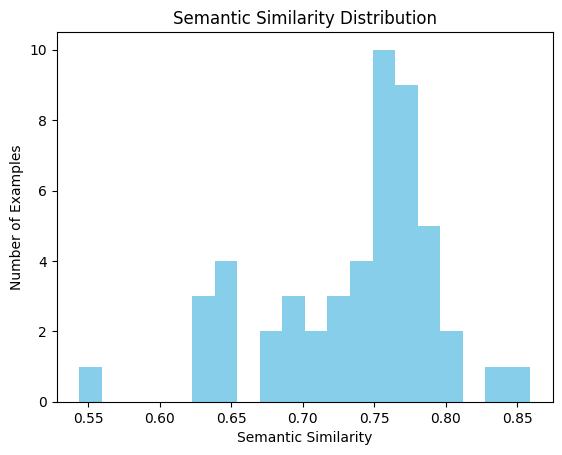

In [37]:
plt.hist(result_df["semantic_similarity"], bins=20, color='skyblue')
plt.xlabel("Semantic Similarity")
plt.ylabel("Number of Examples")
plt.title("Semantic Similarity Distribution")
plt.show()

In [39]:
print(result_df.sort_values("semantic_similarity").iloc[[0, -1]][["prompt", "reference", "generated", "semantic_similarity"]])

                                               prompt  \
26  Что такое применение правил государственной ре...   
16  Что такое применение гражданского законодатель...   

                                            reference  \
26  Правила государственной регистрации, изложенны...   
16  В отсутствие норм и обычаев сначала применяетс...   

                                            generated  semantic_similarity  
26  Примеры использования.\nПрименение правил госу...             0.543884  
16  При отсутствии прямых норм или обычаев, гражда...             0.859315  


In [40]:
df_semantic = pd.read_csv("sft_with_semantic_similarity.csv")

In [43]:
min_idx = result_df["semantic_similarity"].idxmin()
max_idx = result_df["semantic_similarity"].idxmax()

print("Min. similarity")
print(f"Semantic similarity: {result_df.loc[min_idx, 'semantic_similarity']:.4f}\n")
print(f"PROMPT:\n{result_df.loc[min_idx, 'prompt']}\n")
print(f"REFERENCE:\n{result_df.loc[min_idx, 'reference']}\n")
print(f"GENERATED:\n{result_df.loc[min_idx, 'generated']}\n")

print("\n" + "="*80 + "\n")

print("Max. similarity")
print(f"Semantic similarity: {result_df.loc[max_idx, 'semantic_similarity']:.4f}\n")
print(f"PROMPT:\n{result_df.loc[max_idx, 'prompt']}\n")
print(f"REFERENCE:\n{result_df.loc[max_idx, 'reference']}\n")
print(f"GENERATED:\n{result_df.loc[max_idx, 'generated']}\n")

Min. similarity
Semantic similarity: 0.5439

PROMPT:
Что такое применение правил государственной регистрации прав на имущество, предусмотренных этой статьёй, и в каких случаях они действуют?

REFERENCE:
Правила государственной регистрации, изложенные в статье 8.1 ГК РФ, применяются ко всем ситуациям, когда гражданский кодекс или иной федеральный закон прямо требует внесения записи о праве, об ограничении или обременении имущества — за исключением случаев, когда ГК РФ устанавливает иные специальные процедуры

GENERATED:
Примеры использования.
Применение правил государственной регистрации прав на имущество регулируется Гражданским кодексом Российской Федерации (ГК РФ) и Федеральным законом № 7-ФЗ от 31 января 1996 года «О государственной регистрации прав на недвижимость». Эти правила определяют порядок оформления, изменения и прекращения прав собственности на объекты недвижимости, а также предоставляют гарантии для участников сделок. Они действуют при совершении следующих операций:
1. Оф

In [44]:
N = 3

print("High Min. similarity")
for idx, row in result_df.nsmallest(N, "semantic_similarity").iterrows():
    print(f"Similarity: {row['semantic_similarity']:.4f}")
    print(f"PROMPT:\n{row['prompt']}")
    print(f"REFERENCE:\n{row['reference']}")
    print(f"GENERATED:\n{row['generated']}")
    print("-"*60)

print("High Max. similarity")
for idx, row in result_df.nlargest(N, "semantic_similarity").iterrows():
    print(f"Similarity: {row['semantic_similarity']:.4f}")
    print(f"PROMPT:\n{row['prompt']}")
    print(f"REFERENCE:\n{row['reference']}")
    print(f"GENERATED:\n{row['generated']}")
    print("-"*60)

High Min. similarity
Similarity: 0.5439
PROMPT:
Что такое применение правил государственной регистрации прав на имущество, предусмотренных этой статьёй, и в каких случаях они действуют?
REFERENCE:
Правила государственной регистрации, изложенные в статье 8.1 ГК РФ, применяются ко всем ситуациям, когда гражданский кодекс или иной федеральный закон прямо требует внесения записи о праве, об ограничении или обременении имущества — за исключением случаев, когда ГК РФ устанавливает иные специальные процедуры
GENERATED:
Примеры использования.
Применение правил государственной регистрации прав на имущество регулируется Гражданским кодексом Российской Федерации (ГК РФ) и Федеральным законом № 7-ФЗ от 31 января 1996 года «О государственной регистрации прав на недвижимость». Эти правила определяют порядок оформления, изменения и прекращения прав собственности на объекты недвижимости, а также предоставляют гарантии для участников сделок. Они действуют при совершении следующих операций:
1. Оформлени